In [52]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt

In [17]:
# es_url = 'https://elasticsearch-regulatory-6x-client.service.aws-ue1.consul:9200/{0}'
es_url3 = 'http://10.25.11.123:9200/{0}'
es_resource = 'landgrid_07182018/landgrid/_search'

headers = {
            'Content-Type': 'application/json',
            'Cache-Control': 'no-cache'
        }

In [19]:
url = es_url3.format(es_resource)
payload = {
  "aggregations": {
      "group_state": {
          "terms": {
              "field": "State",
              "size": 100
          },
          "aggregations": {
              "by_type": {
                  "filter": {
                      "term": { 
                          "Type": "Township"
                      }
                  }
              }
          }
      }
  },
  "size": 0
}

r = requests.get(url, headers=headers, json=payload)
print(r.encoding)
result = r.json()

UTF-8


In [25]:
by_state = result["aggregations"]["group_state"]["buckets"]
by_state[:5]

[{'key': 'TX', 'doc_count': 319137, 'by_type': {'doc_count': 249}},
 {'key': 'CA', 'doc_count': 166052, 'by_type': {'doc_count': 4931}},
 {'key': 'MT', 'doc_count': 153269, 'by_type': {'doc_count': 4407}},
 {'key': 'NM', 'doc_count': 126929, 'by_type': {'doc_count': 3607}},
 {'key': 'NV', 'doc_count': 116069, 'by_type': {'doc_count': 3455}}]

In [56]:
by_state_df = pd.DataFrame(by_state)
by_state_df.columns = ['State', 'Documents', 'by_type']

by_state_df["Townships"] = by_state_df.by_type.apply(lambda x: x['doc_count'])
by_state_df.drop(columns=["by_type"], inplace=True, axis=1)
by_state_df.set_index('State', inplace=True)
by_state_df.head()
#by_state_df.dtypes


,Documents,Townships
State,,
TX,319137,249
CA,166052,4931
MT,153269,4407
NM,126929,3607
NV,116069,3455


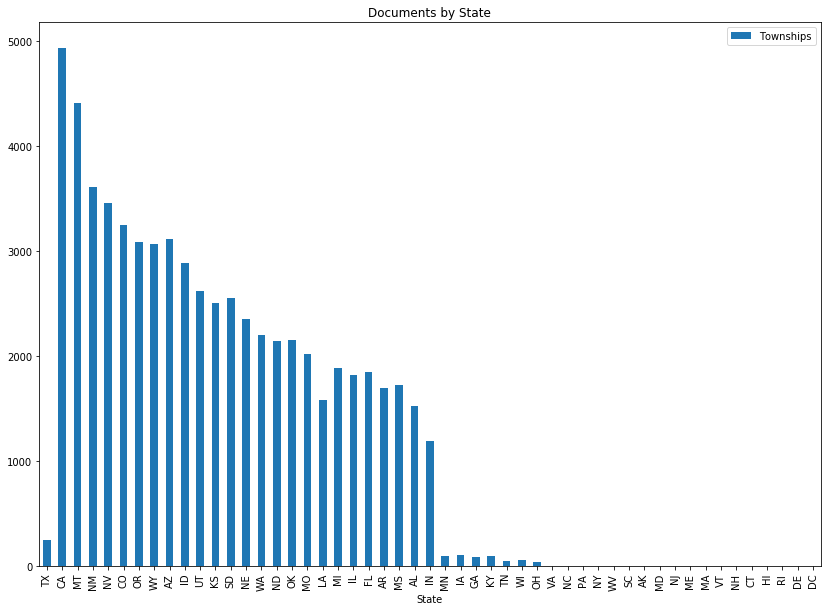

In [62]:
by_state_df.plot.bar(title="Documents by State", y='Townships', figsize=(14, 10))

In [ ]:
# Need to change DNS in Docker
sess = requests.Session()
sess.headers.update(headers)

req = requests.Request('GET',
                       es_url2,
                       params=None,
                       headers=headers)

prepped_request = sess.prepare_request(req)

response = sess.send(
    prepped_request,
    stream=False,
    verify=False,
    proxies={},
    cert=None,
    timeout=None,
    allow_redirects=True)

print(response)